# Particles in Box
**Author: Tadeáš Němec, 2021**


## About
This notebook file implements methods for particle simulations in Julia 1.5.3 language. The principles and several interesting configurations are discussed in this document.

## Problem
In this section the definition of the problem will be discussed as well as ways to obtain a qualitatively interesting solution.

### System of particles
Suppose we have N particles in 2-D space denoted by a position vector $ \vec{r}_i(t) $ and velocity $ \vec{v}_i(t) $. Hence each particle is well defined in phase space $ \Gamma_i = \vec{r} \times \vec{v} \subset \mathbb{R}^4 $. The phase space of all particles is a vector space $\Gamma \subset \mathbb{R}^{4N}$

We can further characterize each particle by its mass $m_i$ and charge $q_i$. Each particle has finite size – we model particles as circle with radius $\sigma$.

For our purposes, we encapsulate particles in a box of a fixed size. 

### Particle interactions
Each particle interacts with its surroundigs and obeys rules as follows:

* If a particle hits the border, it bounces away. We can define restitution coefficient $\rho$ characterizing bounce effect. If $\rho = 1$, the reflection is ideal. If $\rho < 1$, energy of the particle dissipates and for $\rho > 1$ particle receives energy from the border.


* We define collision of 2 particles when the distance between $\vec{r}_j$ and $\vec{r}_k$ is smaller than $(2\sigma)^2$. The final velocity $\vec{v}'$ of a particle denoted as $1$ after collision with particle denoted as $2$ can be found by a following formula:
$$\begin{equation} 
\vec{v}' =  \vec{v}_1 - \rho \frac{2m_2}{m_1 + m_2} \frac{(\vec{v}_1 - \vec{v}_2)\cdot (\vec{r}_1 - \vec{r}_2)}{|| \vec{r}_1 - \vec{r}_2 ||^2} (\vec{r}_1 - \vec{r}_2),
\end{equation} $$ 
where $\rho$ is restitution coefficient, for which similar rules apply as for bounce effect from the walls. 


* Finally, we need to define interactions between particles. Assuming all forces are induced by potentials taking the form: $U_{\alpha}(||\vec{r}_1 - \vec{r}_2||)$, where $\alpha$ denotes arbitrary potential, we can obtain forces as follows: $$\vec{F} = - \nabla_{\vec{r}_1} U_{\alpha}(||\vec{r}_1 - \vec{r}_2||) .$$ 


We have an option to choose arbitrary potential as mentioned above. Such potentials are for example (Note: $r = ||\vec{r}_1 - \vec{r}_2||$):

* **Coulomb potential** inducing force between charged particles: $$U_c = \kappa \frac{q_i q_j}{r},$$where $\kappa$ is a proportionality constant. 

* **Lennard-Jones potential** characterizing simple intermolecular force between particles: 
$$ U_{LJ} = \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left(\frac{\sigma}{r} \right)^{6} \right], $$
where $\varepsilon$ is proportionality constant. We can see the potential as a function of $r$ below. Notice the minimum at $r_m = 2^{1/6} \sigma$:

![Lennard_Jones](images/Lennard_Jones.png)

### Multiparticle system

So far, we have only defined interaction for binary systems. However, we now have all the informations to derive the equations of motion for the particles. 

We know from Lagrangian mechanics that we can describe the whole system by a following **Lagrange function**:
$$\mathcal{L}(\vec{r}_1, ... \vec{r}_N, \vec{v}_1, ..., \vec{v}_N, t) = T + U = \sum_i^N \frac{1}{2} m_i v_i^2 + \sum_{\alpha} \sum_{i,j,i\neq j}^N U_{\alpha}(r_{i,j}), $$
where expression $r_{i,j} = ||\vec{r}_i - \vec{r}_j||$.

From the Lagrange function we can obtain equation of motion by using Euler-Lagrange equations, hence for particle $i$ we solve the following:
$$ \frac{d}{dt} \left( \frac{\partial \mathcal{L}}{\partial \vec{v}_i} \right) - \frac{\partial \mathcal{L}}{\partial \vec{r}_i} = 0.$$

From the formula above we obtain equations of motion for arbitrary particle. Due to the nature of ordinary differential equations, the total net force on the particle is given by addition of force increments induced by surrounding particles. 

### Solution

For $N = 1, 2$ there exists simple analytical solutions. For $N = 2$ by change of coordinates we obtain a famous two body problem. However, for $N = 3, 4, ...$ particles, the best we can do is solve the problem numerically. 

For simplicity, let's now assume we have particle 1 and 2, the latter being at fixed position. Further assume potential of a following form $U \sim \frac{1}{r} $. The equations of motions are as follows:
$$ \ddot{\vec{r}}_1 = \frac{1}{m_1} \frac{(\vec{r}_1 - \vec{r}_2)}{r^3} $$

We would like to transform the equation into a set of first order ordinary differential equations. This can be done simply by the following substitution (in 2-D, $\vec{r} = (x, y) = (u_1, u_2)$):
$$ \dot{u}_1 = u_3 \\
                 \dot{u}_2 = u_4 \\
                 \dot{u}_3 = \frac{1}{m_1} \frac{(u_1 - x_2)}{r^3} \\
                 \dot{u}_4 = \frac{1}{m_1} \frac{(u_1 - y_2)}{r^3}.
$$

With a vector of initial conditions $(u_1, u_2, u_3, u_4)^T = (x_1, y_1, v_{x,1}, v_{y,1})^T $ the system is complete and the solution is certain to exist.

### Numerical solution

The set of equations for $\vec{u}$ can be solved numerically by utilizing certain numerical method. In this notebook, explicit Euler method of the first order and explicit Runge-Kutta method of the fourth order are implemented. 

The natural question is, how many times do we have to iterate to obtain a solution?

Let's demonstrate this on a set of N particles with RK4 (Runge-Kutta 4th order) method. 
* Initially we have N particles, hence 2N equations of motion, which are second order ODE's. As mentioned at the end of the previous section, more appropriate way is to solve a set of first order ODE's. Therefore we now have 4N 1st order ODE's.

* For each particle, we must add up all contributions of binary interactions between particles, therefore we now have to evaluate N-1 potential forces. Since RK4 method evaluates function at 4 points, we need to consider this in our assumption. 

In total, for one iteration, we need to iterate for $N \times (4\times (N-1))$ steps, which is of order of algorithmic difficulty $\mathcal{o}(N^2)$. This process could be, however, pretty well optimalized for multicore computation. Further, the numerical precision could be lowered to single precision. This is not considered in this document, though. 

Finally, one must select reasonably small time increment $dt$ for computation, so the simulation can give interesting output. 



In [1]:

using Plots

In [2]:
### Object declaration
mutable struct Particle
    # Position
    x::Number
    y::Number
    # Velocity
    v_x::Number
    v_y::Number
    # Other properties: mass, charge
    m::Number
    q::Number
    
    # Constructors
    Particle(x, y, v_x, v_y, m, q) = new(x, y, v_x, v_y, m, q)
    Particle(x, y, v_x, v_y) = new(x, y, v_x, v_y, 1, 0)
    Particle(arg, m, q) = new(arg[1], arg[2], arg[3], arg[4], m, q)
    
end

function phase_trajectories(p::Particle)
    return (p.x, p.y, p.v_x, p.v_y)
end


phase_trajectories (generic function with 1 method)

In [3]:
function Base.:+(p::Particle, y)
    return Particle(p.x + y[1], p.y + y[2], p.v_x + y[3], p.v_y + y[4], p.m, p.q)
end

In [41]:
### Proportionality constants: 
### Coulomb potential & Lennard-Jones potential & Gravitational force
κ = 0.05
ε = 1.
g = 1.
###
### Particle cross section radius
σ = 0.02
### Restitution coefficient
ρ = 0.8
### Box dimensions
dims = (-1.,1.)
### Box effect [left, right, bottom, top], 1 = normal restitution, >1 = acceleration, <1 = decceleration
effect = (0.9, 0.9, 0.9, 0.9)
### Maximum effective radius for force interaction
R = 10.


function step(
        particles, 
        i, 
        dt, 
        method,
        F
    )
    position = zeros(4)
    p = particles[i]

    position = collisions(particles, i, dt)
    
    ### Trajectory and speed in the next step

    if method == "RK4"
        position = RK4(
            forces, 
            Particle(position, p.m, p.q), 
            particles,
            i,
            dt,
            F
        )
    elseif method == "Euler"
        position = Euler(
            forces, 
            Particle(position, p.m, p.q), 
            particles,
            i,
            dt,
            F
        )
    end
            
    return position
end


function forces(p1, index, particles, F)
    a1, a2 = 0., 0.
    Coulomb, Lennard_Jones, g_force = F
    ### Adding up increments of forces induced by other particles
    for (i, p2) in enumerate(particles)
        if (index != i)
            r = sqrt((p1.x-p2.x)^2 + (p1.y-p2.y)^2)
            ### Effective radius
            if (r < R)
                if(Coulomb)
                    (a1, a2) = [a1, a2]+
                               [p1.x-p2.x, p1.y-p2.y] * p1.q*p2.q*κ/p1.m /r^3
                end
                if(Lennard_Jones)
                    (a1, a2) = [a1, a2] + 
                               [-ε*(p1.x - p2.x)*(-12*σ^12 / r^7 + 6*σ^6 / r^4),
                                -ε*(p1.y - p2.y)*(-12*σ^12 / r^7 + 6*σ^6 / r^4)]
                end
            end
        end
    end
    
    if(g_force)
        a2 = a2 - g
    end
    
    return [p1.v_x, p1.v_y, a1, a2]
end


function trajectories(
        particles, 
        t_range::Tuple, 
        N, 
        method, 
        F
    )
    dt = (t_range[2] - t_range[1])/N
    trajectories = zeros(N + 1, 4 * length(particles))
    for (index, p) in enumerate(particles)
        trajectories[1, (4*index-3):(4*index)] .= [p.x, p.y, p.v_x, p.v_y]
    end

    for i in 2:(N + 1)
        for (index, p) in enumerate(particles)               
            ### Boundary effects
            box(p, dt, effect) 
            ### Complete trajectories
            trajectories[i,(4*index-3):(4*index)] .= step(
                particles, 
                index, 
                dt, 
                method, 
                F
                )  
        end
        
        ### Save trajectory into particles
        for (index, p) in enumerate(particles)               
            p.x, p.y, p.v_x, p.v_y = trajectories[i, (4*index-3):(4*index)]   
        end

    end
    
    return trajectories
end


function collisions(particles, i, dt)
    p = particles[i]
    for (index, p_other) in enumerate(particles)
        if (index != i)
            if(is_collision(p, p_other, dt))
                (vx, vy) = direction(p, p_other)
                v = norm([vx, vy])
                ### If v == 0 then division by zero
                if (v <= 0.000001)
                    return [p.x, p.y, vx, vy]
                else
                    ### Set position and velocity (position in the direction
                    ### of the velocity unit vector)
                    direction_v = 1/v*[vx, vy]
                    return [
#                        p.x+direction_v[1]*σ*dt,
#                        p.y+direction_v[2]*σ*dt, 
                        p.x,
                        p.y,
                        vx, 
                        vy
                    ]
                end
            end
        end
    end
    return [p.x, p.y, p.v_x, p.v_y]
end 


function is_collision(p1, p2, dt)
    return ((p1.x+p1.v_x*dt-p2.x-p2.v_x*dt)^2 + 
            (p1.y+p1.v_y*dt-p2.y-p2.v_y*dt)^2 < (2*σ)^2)
end


function is_collision(p1, p2)
    return ((p1.x-p2.x)^2 + 
            (p1.y-p2.y)^2 < (2*σ)^2)
end


### Change of particle direction with respect to collison direction
### src: https://en.wikipedia.org/wiki/Elastic_collision
function direction(p1, p2)
    μ = p1.m + p2.m
    v1, v2 = [p1.v_x, p1.v_y], [p2.v_x, p2.v_y]
    x1, x2 = [p1.x, p1.y], [p2.x, p2.y]

    pv = v1 - ρ*2*p2.m/μ * dot(v1-v2, x1-x2)/norm(x1-x2)^2 * (x1 - x2)

    return pv
    
end


### Dot product between vectors
dot(v1, v2) = sum(v1.*v2)


### Norm of a vector
norm(v) = sqrt(dot(v, v))


### Borders
function box(p, dt, effect)
    px, py, pvx, pvy = p.x, p.y, p.v_x, p.v_y
    if (px <= dims[1]) 
        p.v_x = -p.v_x*effect[1]
        p.x = dims[1]
    end
    if (px >= dims[2])
        p.v_x = -p.v_x*effect[2]
        p.x = dims[2]
    end
    if (py <= dims[1])
        p.v_y = -p.v_y*effect[3]
        p.y = dims[1]
    end
    if (py >= dims[2])
        p.v_y = -p.v_y*effect[4]
        p.y = dims[2]
    end
end


### Randomly generate particles by criteria
function create_particles(N, μ, charges)
    particles = []
    for i in 1:N
        distr = random_distribution(μ)
        ### Random position and velocity
        x, y, vx, vy = distr[1][1], distr[1][2], distr[2][1], distr[2][2]
        if (charges)
            p = Particle(x, y, vx, vy, 1, rand((-1:1)))
        else
            p = Particle(x, y, vx, vy)
        end
        push!(particles, p)
    end
    return particles
end


function maxwell_distribution(N, μ)
    f(v) = sqrt(1/π)*exp(-(v - μ)^2)

    velocities = []
    
    for i in 1:N
        
    end
end


function random_distribution(μ)
    position = (dims[2]-dims[1]-4*σ)*rand(Float64, (2,1)) + (dims[1]+2*σ)*[1,1]
    velocity = (2*μ-4*σ)*rand(Float64, (2,1)) + (-μ+2*σ)*[1,1]
    return [position, velocity]
end


### Create particle grid for targets, a == x length, b == y length
function create_grid(N_particles)
    particles = []
    for j in 0:7
        for k in 0:4
            push!(particles, Particle(-0.3 + 4.1*σ*j, -k*2.1*σ, 0, 0, 1, 0))
        end
    end
    return particles
end


function RK4(f, p1, particles, i, dt, F)
    k1 = f(p1, i, particles, F)
    k2 = f(p1 + dt*k1/2, i, particles, F)
    k3 = f(p1 + dt*k2/2, i, particles, F)
    k4 = f(p1 + dt*k3, i, particles, F)
    
    return phase_trajectories(p1 + dt*(k1 + 2*k2 + 2*k3 + k4)/6)
end


function Euler(f, p1, particles, i, dt, F)
    return phase_trajectories(p1 + dt*f(p1, i, particles, F))
end


@userplot plot_particles
@recipe function f(cp::plot_particles, add_marker = true)
    x, y= cp.args

    aspect_ratio --> 1
    label --> false
    lims --> dims
    markershape --> :circle
    x, y

end


function plot_sol(sol, particles; trajectory = true, anim = true)
    if(trajectory)
        ### Plot full trajectories
        plot(sol[:,1], sol[:,2], lims=dims, aspect_ratio=:equal, label=false, legend=false)
        for (index, p) in enumerate(particles)
            if index == 1
                continue
            end
            plot!(sol[:,(4*index-3)], sol[:,(4*index-2)])
        end
        current()
    end
    
    if(anim)
        ### Colors corresponding to charge:
        colors = Dict(-1 => :blue, 0 => :gray, 1 => :red)

        anim = @animate for i in 1:length(sol[:,1])
            plot_particles(sol[i:i,1], sol[i:i,2], markercolor = colors[particles[1].q])
            for (index, p) in enumerate(particles)
                if index == 1
                    continue
                end
                plot_particles!(sol[i:i,(4*index-3)], sol[i:i,(4*index-2)], markercolor = colors[p.q])
            end
        end
        gif(anim, "particle_sim.gif", fps = 70)

    end
end


function simulation(
        N_particles::Int,
        timeframe::Tuple, 
        N_steps::Int;
        method = "RK4",
        mode = "random",
        μ = 1.,
        vx = 0.1,
        vy = -6,
        charges = false,
        Coulomb = false,
        Lennard_Jones = false,
        g_force = false
    )
    
    particles = []
    
    if (mode == "target")
        particles = create_grid(N_particles)
        ### Bullet particle:
        push!(particles, Particle(0, 0.5, vx, vy, 1, 1))
        charges = false
        Coulomb = false
        Lennard_Jones = false
        g_force = false
    else
        particles = create_particles(N_particles, μ, charges)
    end
    
    F = [Coulomb, Lennard_Jones, g_force]
    
    sol = trajectories(
        particles, 
        timeframe, 
        N_steps, 
        method, 
        F
    )
    
    return sol, particles
end

simulation (generic function with 1 method)

In [5]:
particles = create_particles(20, 1., true)
#particles = [Particle(0.5, 0.5, -0.05, -1, 1, 0), Particle(0.5, 0, 0.01, 1, 1, -1)]
#particles = create_grid()
#push!(particles, Particle(0, 0.5, 0.3, -5, 1, 1))

20-element Array{Any,1}:
 Particle(0.4771459723333884, -0.7378754740064255, 0.39293862879209573, 0.6345784121204359, 1, 1)
 Particle(-0.6521800644774235, -0.572758064373431, -0.09745266015478027, 0.11839113821550096, 1, 1)
 Particle(-0.9335438332887382, -0.09420323783043683, 0.49082852381673736, 0.1953662603594679, 1, 0)
 Particle(0.24564591054534857, 0.35117733654287964, -0.8455412203550432, 0.18902386520396663, 1, 1)
 Particle(0.6514680596495361, -0.11036537354241927, -0.2608364192788979, 0.46753356843976657, 1, -1)
 Particle(-0.13349749613267137, -0.5773839862262647, -0.02929548239057511, 0.7984097268302424, 1, -1)
 Particle(-0.716945310736467, -0.42938772600639263, -0.057778782711684906, 0.14909308413480393, 1, 1)
 Particle(0.11382606057808164, 0.5556031597375186, -0.9283383586412957, -0.7751089789012451, 1, -1)
 Particle(0.35809136762268157, -0.3762325880734141, 0.19880956946686545, 0.23231769891009413, 1, 0)
 Particle(0.32138909662011406, -0.5639614916129672, 0.3228056857528556, 

In [6]:
sol = trajectories(particles, (0,3), 400, "RK4", [true, false, false])

401×80 Array{Float64,2}:
  0.477146  -0.737875   0.392939  …  0.0498374  -0.609555   0.0066981
  0.480076  -0.733099   0.388281     0.0498884  -0.609686   0.00689713
  0.482971  -0.728289   0.383665     0.049941   -0.609794   0.00713925
  0.485831  -0.723445   0.379087     0.0499956  -0.609879   0.00742511
  0.488657  -0.718568   0.374542     0.0500525  -0.60994    0.00775539
  0.491449  -0.713657   0.370028  …  0.0501121  -0.609976   0.00813083
  0.494208  -0.708714   0.365542     0.0501746  -0.609987   0.00855219
  0.496933  -0.703737   0.361079     0.0502405  -0.60997    0.00902023
  0.499624  -0.698728   0.356638     0.05031    -0.609926   0.0095357
  0.502283  -0.693685   0.352214     0.0503836  -0.609853   0.0100993
  0.504908  -0.68861    0.347805  …  0.0504616  -0.60975    0.0107118
  0.5075    -0.683501   0.343408     0.0505444  -0.609615   0.0113738
  0.510059  -0.67836    0.339019     0.0506324  -0.609448   0.0120859
  ⋮                               ⋱                       

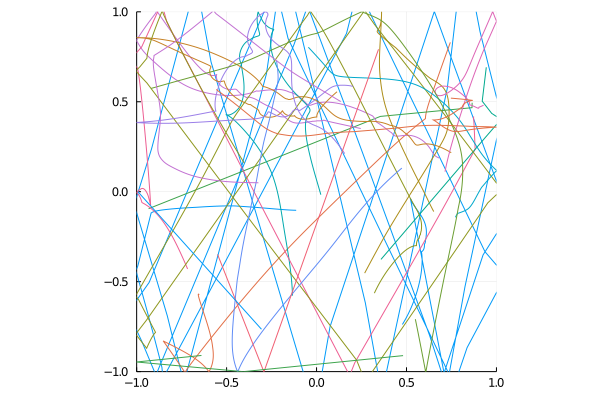

In [7]:
### Plot full trajectories
plot(sol[:,1], sol[:,2], lims=dims, aspect_ratio=:equal, label=false, legend=false)
for (index, p) in enumerate(particles)
    if index == 1
        continue
    end
    plot!(sol[:,(4*index-3)], sol[:,(4*index-2)])
end
current()


In [8]:

@userplot plot_particles
@recipe function f(cp::plot_particles, add_marker = true)
    x, y= cp.args

    aspect_ratio --> 1
    label --> false
    lims --> dims
    markershape --> :circle
    x, y

end



┌ Info: Saved animation to 
│   fn = /Users/tadeasnemec/Programming/Git/Particles_In_Box/particle_sim.gif
└ @ Plots /Users/tadeasnemec/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/tadeasnemec/Programming/Git/Particles_In_Box/particle_sim.gif")
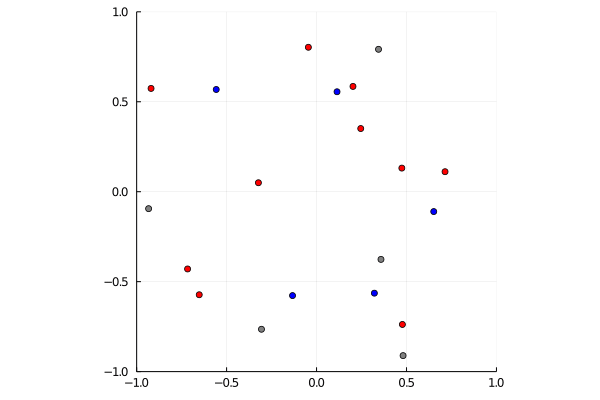

In [9]:
### Colors corresponding to charge:
colors = Dict(-1 => :blue, 0 => :gray, 1 => :red)

anim = @animate for i in 1:length(sol[:,1])
    plot_particles(sol[i:i,1], sol[i:i,2], markercolor = colors[particles[1].q])
    for (index, p) in enumerate(particles)
        if index == 1
            continue
        end
        plot_particles!(sol[i:i,(4*index-3)], sol[i:i,(4*index-2)], markercolor = colors[p.q])
    end
end
gif(anim, "particle_sim.gif", fps = 70)




In [46]:
@time sol, particles = simulation(100, (0,3), 400; mode = "target", method = "RK4", charges = false, Coulomb = true, Lennard_Jones = true, g_force = false)

  1.273870 seconds (30.79 M allocations: 505.869 MiB, 6.67% gc time)


([-0.3 0.0 … 0.1 -6.0; -0.3 0.0 … 0.1 -6.0; … ; -0.8515285534200127 0.021525771281026982 … -0.5004540450762788 0.258928148880605; -0.8518288089362919 0.020937487579976093 … -0.5004540450762788 0.258928148880605], Any[Particle(-0.8518288089362919, 0.020937487579976093, -0.040034068837232595, -0.07843782680678549, 1, 0), Particle(-0.5384019855262151, -0.43950111190230345, -0.01900221920781947, -0.15279675756965874, 1, 0), Particle(-0.987638375604118, 0.054706846167531076, 0.41205414652939476, -0.08801194303089219, 1, 0), Particle(-0.770816438766745, -0.22987653161300184, -0.20248402181007097, -0.05966153525390396, 1, 0), Particle(-0.9503682599491261, -0.6390754082706365, 0.016397954613756316, 0.07668227389008081, 1, 0), Particle(-0.2450639027567314, 0.5629178677276916, 0.9586490123724009, 0.1484777959451684, 1, 0), Particle(-0.8843809021582558, -0.08838745750957111, 0.2752835662898698, 0.025248196811102075, 1, 0), Particle(-0.8426366033746835, 0.22707872971251328, -0.21831642834791784, -

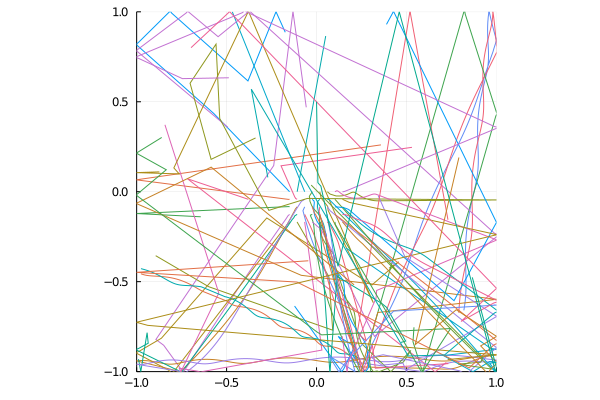

In [39]:
### Plot full trajectories
plot(sol[:,1], sol[:,2], lims=dims, aspect_ratio=:equal, label=false, legend=false)
for (index, p) in enumerate(particles)
    if index == 1
        continue
    end
    plot!(sol[:,(4*index-3)], sol[:,(4*index-2)])
end
current()

┌ Info: Saved animation to 
│   fn = /Users/tadeasnemec/Programming/Git/Particles_In_Box/particle_sim.gif
└ @ Plots /Users/tadeasnemec/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/tadeasnemec/Programming/Git/Particles_In_Box/particle_sim.gif")
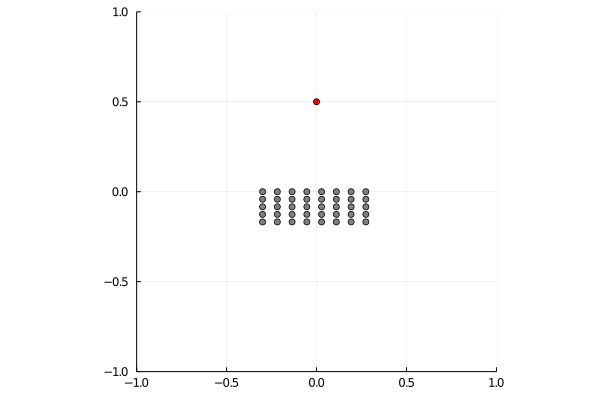

In [47]:
plot_sol(sol, particles; trajectory = true, anim = true)